In [2]:
import warnings
warnings.filterwarnings('ignore')

# find ROIs
hand-picked regions of interest based on the figure

![selected ROIs](./data/ROIs-annotated.png)

In [3]:
# setup brain plot
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
import nibabel
from surfplot import Plot

fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
import pandas as pd

In [5]:
region_names = pd.read_csv('data/regions_sorted.csv')['region']

how to find regions

In [8]:
region_names[region_names.str.startswith('7Networks_RH_Default_PFCdPFCm')]

954     7Networks_RH_Default_PFCdPFCm_1
955     7Networks_RH_Default_PFCdPFCm_2
956     7Networks_RH_Default_PFCdPFCm_3
957     7Networks_RH_Default_PFCdPFCm_4
958     7Networks_RH_Default_PFCdPFCm_5
959     7Networks_RH_Default_PFCdPFCm_6
960     7Networks_RH_Default_PFCdPFCm_7
961     7Networks_RH_Default_PFCdPFCm_8
962     7Networks_RH_Default_PFCdPFCm_9
963    7Networks_RH_Default_PFCdPFCm_10
964    7Networks_RH_Default_PFCdPFCm_11
965    7Networks_RH_Default_PFCdPFCm_12
966    7Networks_RH_Default_PFCdPFCm_13
967    7Networks_RH_Default_PFCdPFCm_14
968    7Networks_RH_Default_PFCdPFCm_15
969    7Networks_RH_Default_PFCdPFCm_16
970    7Networks_RH_Default_PFCdPFCm_17
971    7Networks_RH_Default_PFCdPFCm_18
972    7Networks_RH_Default_PFCdPFCm_19
973    7Networks_RH_Default_PFCdPFCm_20
974    7Networks_RH_Default_PFCdPFCm_21
975    7Networks_RH_Default_PFCdPFCm_22
976    7Networks_RH_Default_PFCdPFCm_23
977    7Networks_RH_Default_PFCdPFCm_24
Name: region, dtype: object

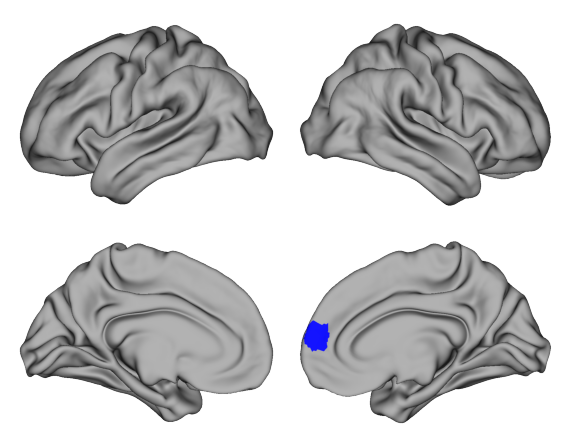

In [21]:
data = pd.Series(region_names).str.startswith('7Networks_RH_Default_PFCdPFCm_8')
# data = pd.Series(region_names)==('7Networks_LH_Default_PFC_4')
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=False, cmap='bwr')
_ = p.build()

In [31]:
seeds = [
    # '7Networks_LH_Default_pCunPCC_15',
    '7Networks_LH_Default_pCunPCC_32',
    '7Networks_LH_Vis_33',
    '7Networks_LH_SomMot_57',
    '7Networks_LH_Default_PFC_19',
    '7Networks_LH_DorsAttn_FEF_5',
    '7Networks_LH_DorsAttn_Post_15',    # the Post_14 is significant
    # '7Networks_LH_Default_Temp_15',
    # '7Networks_LH_Default_PFC_31',
    # '7Networks_LH_Default_PFC_4',

    '7Networks_RH_Default_Par_12',
    '7Networks_RH_DorsAttn_FEF_6',
    '7Networks_RH_Default_pCunPCC_18',
    # '7Networks_RH_Default_PFCdPFCm_15',
    # '7Networks_RH_Default_PFCv_6',
    # '7Networks_RH_Default_PFCdPFCm_14',
    '7Networks_RH_Default_PFCdPFCm_8',
    '7Networks_RH_Vis_45',
    ]

All seed regions plotted on brain. find them separately in appendix 2.

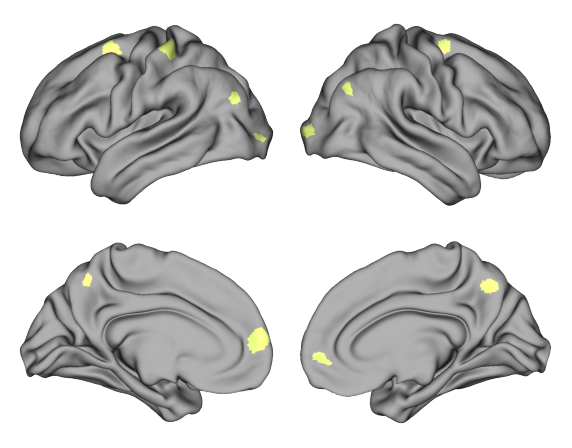

In [32]:
data = pd.Series(region_names).isin(seeds)
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=False, cmap='Wistia')
_ = p.build()

# calculate correlation for seeds
for a seed ROI, calculate connectivity during epochs

In [23]:
EPOCHS = ['baseline', 'early', 'late']

In [24]:
# the list of subjects, removed erroneous ones
subjects = pd.read_csv('data/subjects.csv')
S = subjects.int_id

we are ignoring 'rest' epoch. all calculation on these subjects.

In [25]:
from scipy.stats import pearsonr
from tqdm import tqdm
tqdm.pandas()

In [26]:
# in data/ts/ we don't have cerebellum regions included. only 1012 regions.
def timeseries(subject, epoch): return pd.read_csv('data/ts/ts_'+str(subject)+'_'+epoch+'.csv')

In [28]:
# list0 = []
# for seed in tqdm(seeds):
#     list1 = []
#     for e in EPOCHS:
#         list2 = []
#         for subj in S:
#             ts = timeseries(subj, e)
#             seed_ts = ts[seed]
#             # we neglect pvalue of whether r is significant
#             r = [pearsonr(seed_ts, ts[idx])[0] for idx in ts]   # pearsonr()[0] is rvalue
#             r = pd.DataFrame({'r': r}, index=ts.columns)
#             r.rename_axis('region', inplace=True)
#             r = pd.concat([r], keys=[subj], names=['subject'])
#             list2.append(r)
#         r = pd.concat(list2, 0)
#         r = pd.concat([r], keys=[e], names=['epoch'])   # adds epoch as lower level index
#         list1.append(r)
#
#     dfr = pd.concat(list1, 0)
#     dfr = pd.concat([dfr], keys=[seed], names=['seed_region'])
#     list0.append(dfr)
#
# dfr = pd.concat(list0, 0)

100%|██████████| 1/1 [00:15<00:00, 15.74s/it]


In [27]:
# dfr.to_csv('data/seed_regions.csv')
dfr = pd.read_csv('data/seed_regions.csv')
dfr = dfr.set_index(['seed_region', 'epoch', 'subject', 'region'])

In [29]:
dfr.head()

r
seed_region                     epoch    subject region                      
7Networks_RH_Default_PFCdPFCm_8 baseline 1       7Networks_LH_Vis_1 -0.070683
                                                 7Networks_LH_Vis_2 -0.268002
                                                 7Networks_LH_Vis_3  0.239272
                                                 7Networks_LH_Vis_4  0.159225
                                                 7Networks_LH_Vis_5  0.240594

# average over subjects
average seed connectivity over all subjects during each epoch.

In [30]:
dfr_mean = dfr.groupby(level=[0, 1, 3]).mean()
dfr_mean.head()

r
seed_region                     epoch    region                            
7Networks_RH_Default_PFCdPFCm_8 baseline 7Networks_LH_Cont_Cing_1  0.045249
                                         7Networks_LH_Cont_Cing_2 -0.039806
                                         7Networks_LH_Cont_Cing_3 -0.042232
                                         7Networks_LH_Cont_Cing_4 -0.016594
                                         7Networks_LH_Cont_Cing_5  0.150961

plot mean connectivity of one seed during one epoch

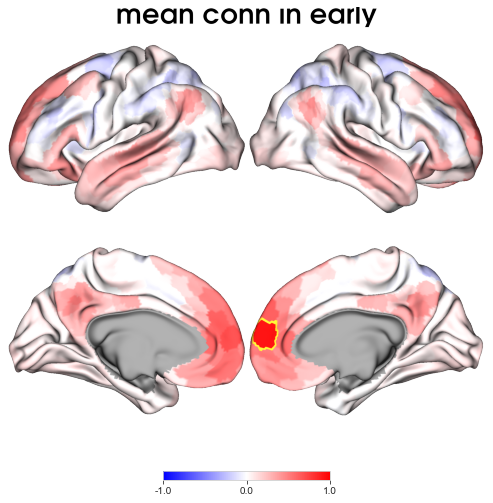

In [31]:
seed = seeds[0]
e = 'early'

data = dfr_mean.loc[seed, e]
data = data.loc[pd.Series(region_names)]['r']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 800),
         label_text={'top': ['mean conn in '+e]})
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-1, 1))
# seed region outlined
data = map_to_labels(pd.Series(region_names)==seed, vertices, mask=(vertices != 0))
p.add_layer(data, cbar=False, as_outline=True)
_ = p.build()

# shift in seed connectivity
using pairwise t-tests between epochs, we can calculate statistical diff for seed region-region link.

In [32]:
import pingouin as pg

In [33]:
def ttest_epochs(df):
    df.index = df.index.droplevel([0,1])
    df = df.unstack(0)
    df.columns = df.columns.droplevel(0)
    b2e = pg.ttest(df['early'], df['baseline'], paired=True, alternative='greater').loc['T-test']
    e2l = pg.ttest(df['late'], df['early'], paired=True, alternative='greater').loc['T-test']
    return pd.Series([b2e['T'], b2e['p-val'], e2l['T'], e2l['p-val']], index=['b2e_t', 'b2e_p', 'e2l_t', 'e2l_p'])

In [34]:
dfr = dfr.round(4)

In [35]:
## to make it shorter only for selected seeds
dfr = dfr.loc[seeds]

In [36]:
dfpairs = dfr.reorder_levels([0,3,1,2]).groupby(level=[0,1]).progress_apply(ttest_epochs)

100%|██████████| 1012/1012 [00:04<00:00, 217.03it/s]


## cortical plots

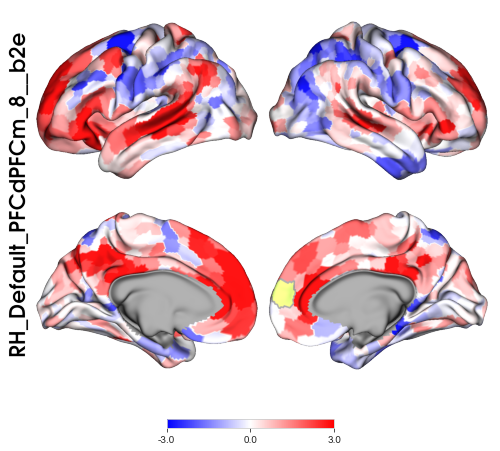

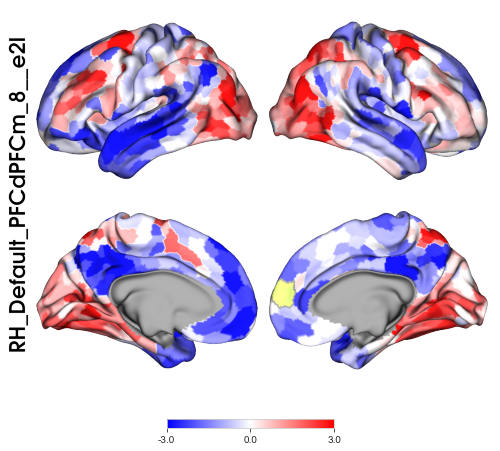

In [38]:
def plot_seed_shift(seed, masked=False, save=False):
    for pair in ['b2e', 'e2l']:
        t, pvalue = pair+'_t', pair+'_p'
        data = dfpairs.loc[seed].loc[region_names] # sort for plotting
        if masked:  data = data.apply(lambda row: row[t] if row[pvalue]<.05 else False, axis=1)
        else: data = data[t]
        data = map_to_labels(data, vertices, mask=(vertices != 0))
        plot = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700), label_text=[seed[10:]+'__'+pair])
        plot.add_layer(data, cbar=True, cmap='bwr', color_range=(-3,3))
        data1 = map_to_labels(region_names==seed, vertices, mask=(vertices != 0))
        plot.add_layer(data1, cbar=False, cmap='Wistia')  # seed region yellowed
        fig = plot.build()
        if save:    fig.savefig('plots/seed/' + seed[10:] +
                                '__' + pair + '__' +
                                ('masked' if masked else 'notMasked') + '.png',
                                dpi=300)

plot_seed_shift(seeds[0], masked=False, save=False)

[None, None]

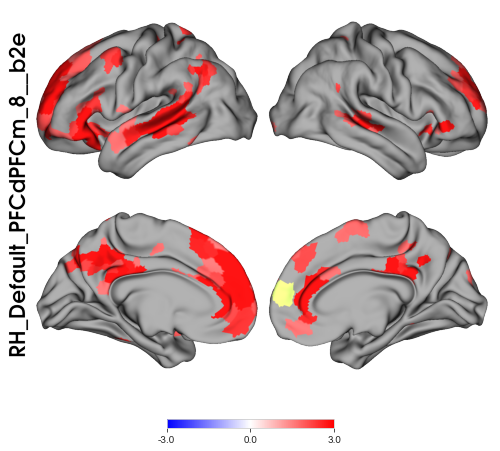

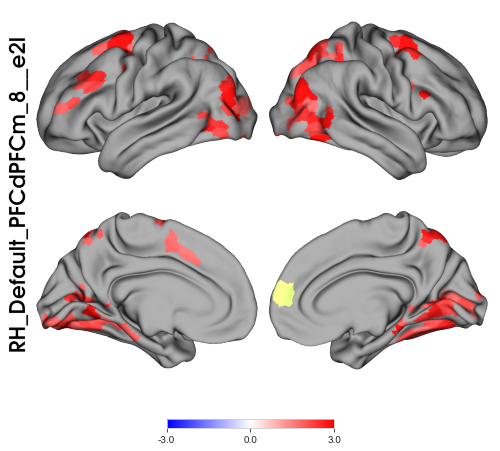

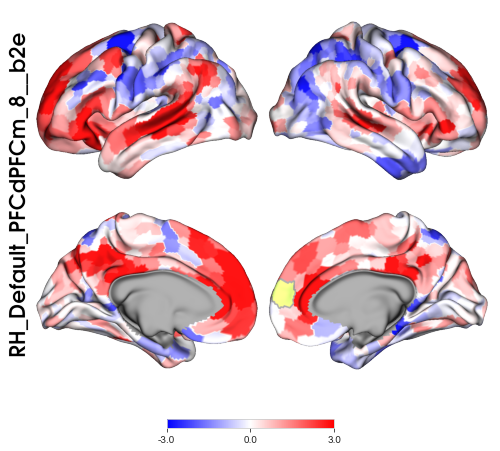

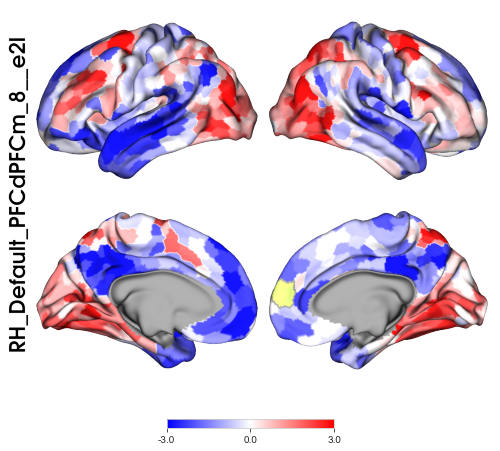

In [39]:
# [plot_seed_shift(s,masked=m,save=True)
#  for s in seeds
#  for m in [True, False]]

## subcortical plots

In [40]:
subcortex_order = ['Left Accumbens',
                     'Left Amygdala',
                     'Left Caudate',
                     'Left Hippocampus',
                     'Left Pallidum',
                     'Left Putamen',
                     'Left Thalamus',
                     # 'Left Ventricles',
                     'Right Accumbens',
                     'Right Amygdala',
                     'Right Caudate',
                     'Right Hippocampus',
                     'Right Pallidum',
                     'Right Putamen',
                     'Right Thalamus',
                     # 'Right Ventricles',
                   ]

In [41]:
from enigmatoolbox.plotting import plot_subcortical

In [42]:
for seed in seeds:
    for pair in ['b2e', 'e2l']:
        t, pvalue = pair+'_t', pair+'_p'
        data = dfpairs.loc[seed].loc[subcortex_order][t] # sort for plotting

        plot_subcortical(data, ventricles=False,
                     size=(800, 400), cmap='bwr', color_bar=True,
                     color_range=(-3,3),
                     screenshot=True, filename= seed[10:] +'__'+ pair +'__subc.png'
                     )

## spider plot

In [88]:
# load network labels

In [52]:
regions_networks = pd.read_csv('data/regions_sorted.csv')
regions_networks = regions_networks.set_index(['region', '7net', '17net'])[[]]
regions_networks.head()

,,
region,7net,17net
7Networks_LH_Vis_1,Vis,DorsAttnA
7Networks_LH_Vis_2,Vis,VisCent
7Networks_LH_Vis_3,Vis,DorsAttnA
7Networks_LH_Vis_4,Vis,VisCent
7Networks_LH_Vis_5,Vis,DefaultC


<AxesSubplot:xlabel='7net'>

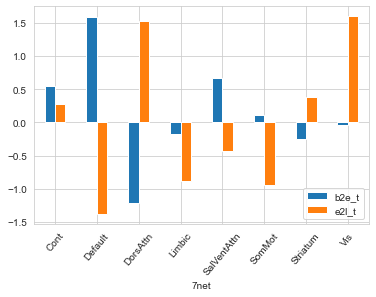

In [53]:
# join pd series on index with regions_networks
# group by network and average
dfpairs.loc[seeds[0]].join(regions_networks).groupby('7net').mean().loc[:,['b2e_t', 'e2l_t']].plot.bar(rot=50)

In [69]:
def spider_df(seed_region, num_nets=7):
    return dfpairs.loc[seed].join(regions_networks).groupby(f'{num_nets}net').mean().loc[:,['b2e_t', 'e2l_t']]

In [70]:
import plotly.graph_objects as go

def plot_spider(seed_region, save=False):
    print(seed_region)

    sdf = spider_df(seed_region)
    nets = sdf.index

    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=sdf['b2e_t'],
        theta=nets,
        fill='toself',
        name='Baseline to Early'
    ))
    fig.add_trace(go.Scatterpolar(
        r=sdf['e2l_t'],
        theta=nets,
        fill='toself',
        name='Early to Late'
    ))
    fig.add_trace(go.Barpolar(
        r=[0.1] * len(nets),
        theta=nets,
        name='zero',
        marker_color='black',
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[-3, 3]  # -4, 4
            )),
        showlegend=True,
    )

    # fig.show()
    if save:    fig.write_image(seed_region[10:]+"-seed-spider.svg")

In [71]:
plot_spider(seeds[0], save=True)

7Networks_RH_Default_PFCdPFCm_8


In [106]:
for seed_region in seeds:
    plot_spider(seed_region, save=True)

7Networks_LH_Default_pCunPCC_32
7Networks_LH_Vis_33
7Networks_LH_SomMot_57
7Networks_LH_Default_PFC_19
7Networks_LH_DorsAttn_FEF_5
7Networks_LH_DorsAttn_Post_15
7Networks_RH_Default_Par_12
7Networks_RH_DorsAttn_FEF_6
7Networks_RH_Default_pCunPCC_18
7Networks_RH_Default_PFCdPFCm_3
7Networks_RH_Vis_45


# appendix 1
the problem with reading t tests results

In [24]:
import seaborn

In [25]:
dfr

r
seed_region                     epoch    subject region                    
7Networks_LH_Default_pCunPCC_32 baseline 1       7Networks_LH_Vis_1 -0.1518
                                                 7Networks_LH_Vis_2 -0.1351
                                                 7Networks_LH_Vis_3  0.0988
                                                 7Networks_LH_Vis_4  0.2525
                                                 7Networks_LH_Vis_5  0.0976
...                                                                     ...
7Networks_LH_SomMot_57          late     46      Right Putamen      -0.0134
                                                 Right Pallidum     -0.1309
                                                 Right Hippocampus  -0.0707
                                                 Right Amygdala      0.0245
                                                 Right Accumbens     0.0067

[437184 rows x 1 columns]

In [26]:
# how to interpret pingouin
d = dfr.reorder_levels([0,3,1,2])
d = d.loc['7Networks_LH_Default_PFC_19','7Networks_RH_Default_PFCdPFCm_15']
d

r
epoch    subject        
baseline 1        0.2605
         2        0.2049
         3        0.2595
         4        0.0093
         6        0.4127
...                  ...
late     40       0.2537
         41       0.5943
         44       0.1513
         45       0.2802
         46       0.4686

[108 rows x 1 columns]

In [27]:
# dfr.reset_index()[dfr.reset_index().region.str.startswith('7Networks_RH_Def')]

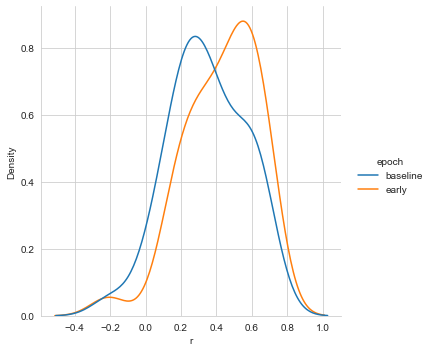

In [28]:
seaborn.displot(d.iloc[:-36], x='r', hue='epoch', kind='kde')

In [29]:
d = d.unstack(0)
d = d['r']
print('paired t tests early, baseline:', pg.ttest(d['early'], d['baseline'],
         alternative='greater', paired=True).loc['T-test', 'T'])    # if paired=False, result is pairwise_ttests
d['b2e'] = d.early - d.baseline
print('one sample early minus baseline:', pg.ttest(d.b2e, 0, alternative='greater').loc['T-test', 'T'])
print('both showing the shift from baseline to early (b2e)')

paired t tests early, baseline: 2.275757303297149
one sample early minus baseline: 2.275757303297149
both showing the shift from baseline to early (b2e)


In [30]:
dfpairs.loc['7Networks_LH_Default_PFC_19','7Networks_RH_Default_PFCdPFCm_15']

b2e_t    2.275757
b2e_p    0.014545
e2l_t   -2.523473
e2l_p    0.991843
Name: (7Networks_LH_Default_PFC_19, 7Networks_RH_Default_PFCdPFCm_15), dtype: float64

In [31]:
dfr.loc['7Networks_LH_Default_pCunPCC_32']

r
epoch    subject region                    
baseline 1       7Networks_LH_Vis_1 -0.1518
                 7Networks_LH_Vis_2 -0.1351
                 7Networks_LH_Vis_3  0.0988
                 7Networks_LH_Vis_4  0.2525
                 7Networks_LH_Vis_5  0.0976
...                                     ...
late     46      Right Putamen       0.0004
                 Right Pallidum      0.0081
                 Right Hippocampus   0.1721
                 Right Amygdala      0.1688
                 Right Accumbens     0.0886

[109296 rows x 1 columns]

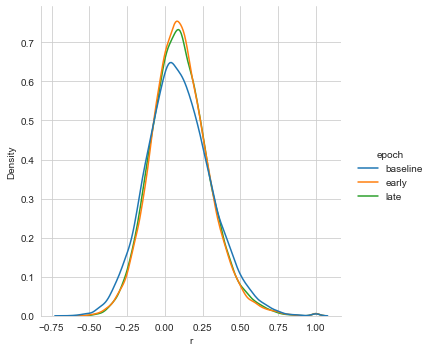

In [32]:
seaborn.displot(dfr.loc['7Networks_LH_Default_pCunPCC_32'], x='r', hue='epoch', kind='kde')

# appendix 2

In [ ]:
for s in seeds:
    data = region_names == s
    data = map_to_labels(data, vertices, mask=(vertices != 0))
    p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300), label_text=[s[10:]])
    p.add_layer(data, cbar=False, cmap='Wistia')
    _ = p.build()